In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Khai báo thư viện & Tải Dữ liệu (Setup)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os

# Sklearn cho việc chia dữ liệu
from sklearn.model_selection import train_test_split

# Tensorflow/Keras cho mô hình Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để kết quả giống nhau mỗi lần chạy (Reproducibility)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Đã import xong thư viện!")

✅ Đã import xong thư viện!


In [3]:
# Tên file dữ liệu của bạn
FILE_NAME = '/content/drive/MyDrive/Cuối kỳ I năm 4/DT_Analysis_for_lifesciene/Data/FC_plus_RES_withPredictions.csv'

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"❌ LỖI: Không tìm thấy file '{filepath}'. Hãy upload file lên Colab trước!")
        return None, None

    print(f"✅ Đang đọc file '{filepath}'...")
    df = pd.read_csv(filepath)

    # 1. Xử lý Input (Sequence)
    # Cắt chuỗi 30mer lấy 23 ký tự quan trọng (từ vị trí 4 đến 27)
    # Cấu trúc: 4bp đầu + [23bp LÕI] + 3bp đuôi
    sequences = df['30mer'].apply(lambda x: x[4:27]).tolist()

    # 2. Xử lý Output (Target)
    # Cột 'score_drug_gene_rank' là điểm hiệu quả thực tế (đã chuẩn hóa 0-1)
    targets = df['score_drug_gene_rank'].values

    print(f"-> Tổng số mẫu: {len(sequences)}")
    return sequences, targets

# Chạy hàm load data
raw_sequences, raw_targets = load_data(FILE_NAME)

✅ Đang đọc file '/content/drive/MyDrive/Cuối kỳ I năm 4/DT_Analysis_for_lifesciene/Data/FC_plus_RES_withPredictions.csv'...
-> Tổng số mẫu: 5310


# **2: Tiền xử lý (Preprocessing)**
Biến đổi chuỗi DNA (A, C, G, T) thành ma trận số (One-Hot Encoding) và chia tập Train/Test.

In [4]:
# --- BLOCK 2: TIỀN XỬ LÝ (ONE-HOT ENCODING) ---

def one_hot_encode(seq_list):
    print("🔄 Đang mã hóa dữ liệu...")
    # Bản đồ chuyển ký tự thành vector
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0] # Xử lý nhiễu nếu có
    }

    encoded_data = []
    for seq in seq_list:
        # Chỉ lấy chuỗi đúng độ dài 23
        if len(seq) == 23:
            vec = [mapping.get(base, [0,0,0,0]) for base in seq]
            encoded_data.append(vec)

    return np.array(encoded_data)

if raw_sequences is not None:
    # 1. Mã hóa
    X = one_hot_encode(raw_sequences)
    y = raw_targets

    # 2. Chia tập dữ liệu (80% Train, 10% Val, 10% Test)
    # Bước 1: Tách 20% ra làm Temp (để sau này chia đôi thành Val/Test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

    # Bước 2: Tách Temp thành Val (10%) và Test (10%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print("\n📊 KẾT QUẢ CHIA TẬP:")
    print(f"   - Input Shape: {X.shape}")
    print(f"   - Train set: {len(X_train)} mẫu")
    print(f"   - Val set:   {len(X_val)} mẫu")
    print(f"   - Test set:  {len(X_test)} mẫu")

🔄 Đang mã hóa dữ liệu...

📊 KẾT QUẢ CHIA TẬP:
   - Input Shape: (5310, 23, 4)
   - Train set: 4248 mẫu
   - Val set:   531 mẫu
   - Test set:  531 mẫu


# **3: Xây dựng & Huấn luyện Model (Training)**
Đây là phần quan trọng nhất: Model Hybrid CNN-LSTM

In [5]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# --- BLOCK 3: MODEL CNN-LSTM ---

def build_final_model():
    inputs = Input(shape=(23, 4))

    # --- NHÁNH 1: Quét chi tiết (Kernel 3) ---
    b1 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    b1 = BatchNormalization()(b1)

    # --- NHÁNH 2: Quét trung bình (Kernel 5) ---
    b2 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    b2 = BatchNormalization()(b2)

    # --- NHÁNH 3: Quét rộng (Kernel 7) - MỚI THÊM VÀO ---
    b3 = Conv1D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    b3 = BatchNormalization()(b3)

    # Ghép 3 nhánh
    merged = Concatenate()([b1, b2, b3])
    merged = Dropout(0.3)(merged)

    # LSTM để học ngữ cảnh
    lstm = Bidirectional(LSTM(128, return_sequences=True))(merged)
    lstm = Dropout(0.3)(lstm)

    # Attention đơn giản (Global Average Pooling)
    pooled = GlobalAveragePooling1D()(lstm)

    # Output
    dense = Dense(128, activation='relu')(pooled)
    dense = Dropout(0.4)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)

    # Compile
    model = Model(inputs=inputs, outputs=outputs)
    # Giảm Learning Rate xuống thấp hơn chút nữa để học kỹ
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])

    return model

# 1. Khởi tạo model mới
model = build_final_model()
model.summary()

# 2. Thiết lập Callbacks (Tự động lưu model tốt nhất)
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Tên file sẽ lưu
    monitor='val_loss',       # Canh chừng val_loss
    save_best_only=True,      # Chỉ lưu khi tìm được model tốt hơn
    mode='min',               # Loss càng nhỏ càng tốt
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,              # Dừng nếu 15 epoch liên tiếp không khá hơn
    restore_best_weights=True
)

# 3. Bắt đầu Train
print("\n🚀 BẮT ĐẦU HUẤN LUYỆN...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,               # Số vòng tối đa
    batch_size=16,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)
print("\n✅ Huấn luyện hoàn tất! Model tốt nhất đã lưu tại 'best_model.keras'")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 23, 64)    │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 23, 64)    │      1,344 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 23, 64)    │      1,856 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 23, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 23, 192)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 23, 192)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 23, 256)   │    328,704 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 23, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 366,529 (1.40 MB)

 Trainable params: 366,145 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)


🚀 BẮT ĐẦU HUẤN LUYỆN...
Epoch 1/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0786 - mae: 0.2406
Epoch 1: val_loss improved from inf to 0.07952, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0786 - mae: 0.2406 - val_loss: 0.0795 - val_mae: 0.2461
Epoch 2/100
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0709 - mae: 0.2248
Epoch 2: val_loss improved from 0.07952 to 0.07331, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0709 - mae: 0.2248 - val_loss: 0.0733 - val_mae: 0.2281
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0667 - mae: 0.2154
Epoch 3: val_loss improved from 0.07331 to 0.07231, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0667 - mae: 0.2154 - val_loss: 0.0723 - val_mae: 0.2223
Epoch 4/100
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0637 - mae: 0.2092
Epoch 4: val_loss improved from 0.07231 to 0.06903, saving model to

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
--------------------------------------------------
🎯 KẾT QUẢ TRÊN TẬP TEST:
   Spearman Correlation: 0.6624
--------------------------------------------------


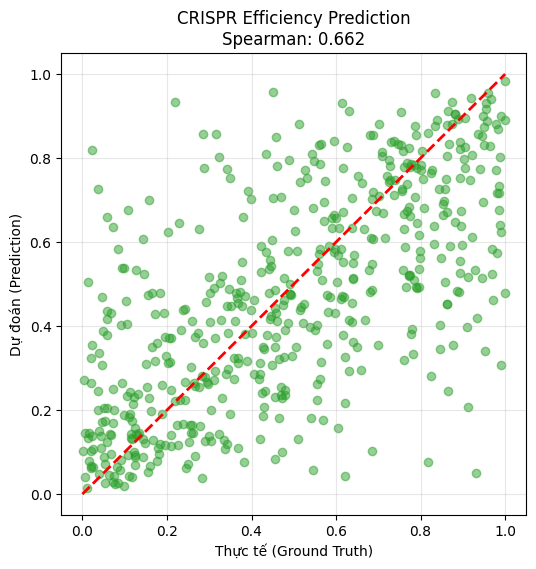

In [6]:
# --- BLOCK 4: ĐÁNH GIÁ KẾT QUẢ ---

# 1. Load lại model tốt nhất (để chắc chắn không dùng model ở epoch cuối cùng bị overfit)
final_model = load_model('best_model.keras')

# 2. Dự đoán trên tập Test (Dữ liệu model chưa từng thấy)
y_pred = final_model.predict(X_test).flatten()

# 3. Tính độ tương quan Spearman
spearman_corr, _ = spearmanr(y_test, y_pred)

print("--------------------------------------------------")
print(f"🎯 KẾT QUẢ TRÊN TẬP TEST:")
print(f"   Spearman Correlation: {spearman_corr:.4f}")
print("--------------------------------------------------")
# Gợi ý: Spearman > 0.6 là Tốt, > 0.7 là Rất tốt cho bài toán này.

# 4. Vẽ biểu đồ so sánh
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='#2ca02c') # Màu xanh lá
plt.plot([0, 1], [0, 1], 'r--', linewidth=2) # Đường chuẩn
plt.xlabel('Thực tế (Ground Truth)')
plt.ylabel('Dự đoán (Prediction)')
plt.title(f'CRISPR Efficiency Prediction\nSpearman: {spearman_corr:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# --- 1. HÀM XỬ LÝ ĐẦU VÀO (GIỐNG HỆT LÚC TRAIN) ---
def encode_sequence(seq_list):
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0]
    }
    encoded = []
    for seq in seq_list:
        # Đảm bảo chuỗi dài đúng 23 ký tự
        # Nếu ngắn hơn hoặc dài hơn thì cắt/bỏ qua (đơn giản hóa cho ví dụ)
        if len(seq) == 23:
            vec = [mapping.get(base, [0,0,0,0]) for base in seq]
            encoded.append(vec)
        else:
            print(f"⚠️ Cảnh báo: Chuỗi '{seq}' không đúng độ dài 23 ký tự!")
    return np.array(encoded)

# --- 2. TẠO DỮ LIỆU MẪU (VÍ DỤ THỰC TẾ) ---
# Giả sử đây là 3 vị trí bạn định cắt trên Gen
sample_sequences = [
    "GGGTGGGGGGAGTTTGCTCCAGG", # Mẫu 1 (Nhiều G - Thường hiệu quả cao)
    "TTTAAAATTTCTTTATATTTAGG", # Mẫu 2 (Nhiều T/A - Thường hiệu quả thấp)
    "CAGAAAAAAAAACACTGCAACAA"  # Mẫu 3 (Ngẫu nhiên)
]

# --- 3. DỰ ĐOÁN ---
# Load model đã train xong
print("🔄 Đang load model 'best_model.keras'...")
try:
    model = load_model('best_model.keras')

    # Mã hóa input
    X_sample = encode_sequence(sample_sequences)

    # Model dự đoán
    if len(X_sample) > 0:
        predictions = model.predict(X_sample)

        print("\n📊 KẾT QUẢ DỰ ĐOÁN HIỆU QUẢ CRISPR:")
        print("-" * 60)
        print(f"{'SEQUENCE (23bp)':<30} | {'SCORE':<10} | {'ĐÁNH GIÁ'}")
        print("-" * 60)

        for seq, score in zip(sample_sequences, predictions):
            val = score[0]
            # Đánh giá sơ bộ
            if val > 0.7: evaluation = "🌟 Cao (Nên dùng)"
            elif val > 0.4: evaluation = "⚠️ Trung bình"
            else: evaluation = "❌ Thấp (Tránh dùng)"

            print(f"{seq:<30} | {val:.4f}     | {evaluation}")
        print("-" * 60)

except Exception as e:
    print(f"❌ Lỗi: Không tìm thấy file model hoặc lỗi dự đoán. ({e})")

🔄 Đang load model 'best_model.keras'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step

📊 KẾT QUẢ DỰ ĐOÁN HIỆU QUẢ CRISPR:
------------------------------------------------------------
SEQUENCE (23bp)                | SCORE      | ĐÁNH GIÁ
------------------------------------------------------------
GGGTGGGGGGAGTTTGCTCCAGG        | 0.4399     | ⚠️ Trung bình
TTTAAAATTTCTTTATATTTAGG        | 0.0097     | ❌ Thấp (Tránh dùng)
CAGAAAAAAAAACACTGCAACAA        | 0.1001     | ❌ Thấp (Tránh dùng)
------------------------------------------------------------
